Реализовать аналогичное изученному дерево решений, использующее энтропию Шенонна в качестве критерия информативности и сравнить точность(accuracy, balanced_accuracy) достигаемую на используемых синтетических данных с точностью разобранной на уроке реализации

In [1]:
import matplotlib.pyplot as plt
import random
import math

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

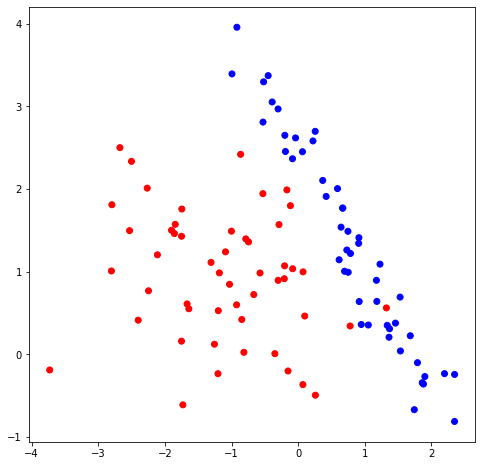

In [2]:
# сгенерируем данные
classification_data, classification_labels = datasets.make_classification(n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=15)

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

In [9]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле
        
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction  

In [10]:

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    # impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity = -1*p*math.log2(p) # Что бы не переделывать всю программу заменем сделать на формулу энтропией Шеннона
        # impurity -= p ** 2
    return impurity


def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)


# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels


# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index


# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)



def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)
    
    
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [11]:
from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels)
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    
print_tree(my_tree)

Индекс 0
Порог 0.09910021047912587
--> True:
  Индекс 1
  Порог 2.4181429263565386
  --> True:
    Прогноз: 0
  --> False:
    Прогноз: 1
--> False:
  Индекс 0
  Порог 0.7802286765985396
  --> True:
    Индекс 0
    Порог 0.6681196633755955
    --> True:
      Прогноз: 1
    --> False:
      Прогноз: 1
  --> False:
    Прогноз: 1


In [12]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)

# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    return np.sum(actual==predicted)/len(actual)

def balanced_accuracy_metric(actual, predicted):
    true_predicted=(actual==predicted).astype(int)
    sensitivity=np.sum(actual*true_predicted)/np.sum(actual==1)
    specificity=np.sum((1-actual)*true_predicted)/np.sum(actual==0)
    return 0.5*(sensitivity+specificity)

In [13]:
# Точность на обучающей выборке
train_accuracy=accuracy_metric(train_labels, train_answers)
accuracy_metric(train_labels, train_answers), balanced_accuracy_metric(train_labels, train_answers)

(0.9714285714285714, 0.9705882352941176)

In [14]:
# Точность на тестовой выборке
test_accuracy=accuracy_metric(test_labels, answers)
accuracy_metric(test_labels, answers), balanced_accuracy_metric(test_labels, answers)

(0.9, 0.9027149321266968)